In [24]:
import requests
import pandas as pd
from pandas import DataFrame
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

URL_VIX = 'https://za.investing.com/indices/volatility-s-p-500-historical-data?end_date=1596617279&st_date=1278367200'
URL_GOLD = 'https://za.investing.com/commodities/gold-historical-data?end_date=1596551414&st_date=1280268000'
URL_SILVER = 'https://za.investing.com/commodities/silver-historical-data?end_date=1596551414&st_date=1280268000'
URL_USD_EUR = 'https://za.investing.com/currencies/eur-usd-historical-data?end_date=1596551414&st_date=1280268000'
URL_USD_CNY = 'https://za.investing.com/currencies/usd-cny-historical-data?end_date=1596551414&st_date=1280268000'

headers = {'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36"}

df = DataFrame()

def extract_data(URL):
    
    page = requests.get(URL, headers = headers).text
    soup = BeautifulSoup(page, 'lxml')
    table = soup.find("table", attrs={"class": "common-table medium js-table"})

    prices_table_data_rows = table.tbody.find_all("tr")  # contains 2 rows
    data = {}
    t_headers = []
    for th in table.find_all("th"):
        t_headers.append(th.text.replace('\n', ' ').strip())


    table_data = []
    for tr in table.tbody.find_all("tr"): # find all tr's from table's tbody
        t_row = {}

        for td, th in zip(tr.find_all("td"), t_headers): 
            t_row[th] = td.text.replace('\n', '').strip()
        table_data.append(t_row)
    return table_data





df = DataFrame(extract_data(URL_VIX))
df['Index'] = 'VIX'
df1 = DataFrame(extract_data(URL_GOLD))
df1['Index'] = 'GOLD'
df2 = DataFrame(extract_data(URL_SILVER))
df2['Index'] = 'SILVER'
df3 = DataFrame(extract_data(URL_USD_EUR))
df3['Index'] = 'USD_EUR'
df4 = DataFrame(extract_data(URL_USD_CNY))
df4['Index'] = 'USD_CNY'


frames = [df,df1,df2,df3,df4]
result = pd.concat(frames)


In [25]:
def extract_cpi(URL):
    page = requests.get(URL, headers = headers).text
    soup = BeautifulSoup(page, 'lxml')
    table = soup.find("table", attrs={"class": "regular"})

    prices_table_data_rows = table.tbody.find_all("tr")  
    data = {}
    t_headers = []
    for th in table.find_all("th"):
        t_headers.append(th.text.replace('\n', ' ').strip())


    table_data = []
    for tr in table.tbody.find_all("tr"): 
        t_row = {}
        
      
        for td, th in zip(tr.find_all("td"), t_headers): 
            t_row[th] = td.text.replace('\n', '').strip()
            
        table_data.append(t_row)

    return table_data

In [26]:
cpi_df = extract_cpi('https://www.bls.gov/regions/mid-atlantic/data/consumerpriceindexhistorical_us_table.htm')

cpi_df = DataFrame(cpi_df)
cpi_df = cpi_df.set_axis(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], axis=1, inplace=False)
cpi_df=cpi_df[:12]
cpi_df=cpi_df.drop(cpi_df.index[0])
year = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
cpi_df.insert(0, 'Year', year)

cpi_final_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Date', value_name='Value')

In [27]:
result['Date'] = pd.to_datetime(result['Date'])

In [28]:
result['Price'] = result['Price'].str.replace(',','')
result['Price'] = pd.to_numeric(result['Price'])

result['Open'] = result['Open'].str.replace(',','')
result['Open'] = pd.to_numeric(result['Open'])

result['High'] = result['High'].str.replace(',','')
result['High'] = pd.to_numeric(result['High'])

result['Low'] = result['Low'].str.replace(',','')
result['Low'] = pd.to_numeric(result['Low'])


In [29]:
result['Mid'] = (result['High']+ result['Low'])/2


In [30]:
m2_df = pd.read_excel('M2.xls')
m2_df = m2_df.rename({'m2': 'Mid'}, axis=1) 
m2_df['Index'] = 'M2'


In [31]:
#merged_df=pd.merge(result, m2_df[['Date','Mid','Index']],on='Date', how='left')

frames1 = [result, m2_df]
final_frame=pd.concat(frames1)


In [32]:
df = final_frame.groupby(['Date', 'Index'], as_index=False)['Mid'].sum()

In [33]:
df.drop(df[df['Date'] < '2010-07-28'].index, inplace=True)


In [34]:
df['Mid'].isnull().sum()


0

In [35]:
#result.drop(['Date','High','Low','Open','Volume','Chg%','Mid','Volume'],1,inplace =True)
table = df.pivot(index='Date', columns='Index', values='Mid')

df_corr = table.corr()
print(df_corr)

Index        GOLD        M2    SILVER   USD_CNY   USD_EUR       VIX
Index                                                              
GOLD     1.000000  0.008220  0.639122  0.121865  0.252101  0.414322
M2       0.008220  1.000000 -0.697788  0.645115 -0.759132  0.066317
SILVER   0.639122 -0.697788  1.000000 -0.308805  0.747091  0.176403
USD_CNY  0.121865  0.645115 -0.308805  1.000000 -0.581528  0.182595
USD_EUR  0.252101 -0.759132  0.747091 -0.581528  1.000000  0.069163
VIX      0.414322  0.066317  0.176403  0.182595  0.069163  1.000000


In [36]:
df_corr['GOLD'].sort_values(ascending=False)

Index
GOLD       1.000000
SILVER     0.639122
VIX        0.414322
USD_EUR    0.252101
USD_CNY    0.121865
M2         0.008220
Name: GOLD, dtype: float64

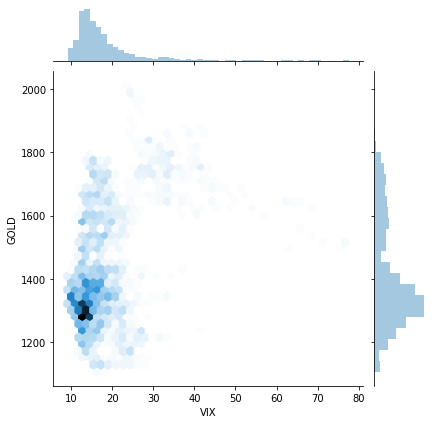

In [37]:
sns.jointplot(x =table['VIX'], y = table['GOLD'], kind='hex')

Text(0.5, 1.05, 'Correlation of Features')

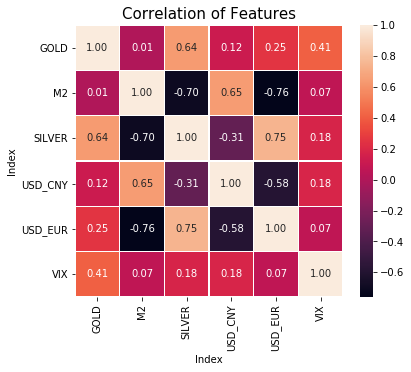

In [38]:
plt.figure(figsize = (6,5))
sns.heatmap(df_corr,
            xticklabels=df_corr.columns.values,
            yticklabels=df_corr.columns.values,
            annot=True,fmt='.2f',linewidths=0.30)
plt.title('Correlation of Features', y = 1.05, size=15)

In [39]:

table['M2'] = table['M2'].fillna(method='bfill')
table['SILVER'] = table['SILVER'].fillna(method='bfill')
table['USD_CNY'] = table['USD_CNY'].fillna(method='bfill')
table['USD_EUR'] = table['USD_EUR'].fillna(method='bfill')
table['VIX'] = table['VIX'].fillna(method='bfill')
table['GOLD'] = table['GOLD'].fillna(method='bfill')

table['M2'] = table['M2'].fillna(method='ffill')
table['SILVER'] = table['SILVER'].fillna(method='ffill')
table['USD_CNY'] = table['USD_CNY'].fillna(method='ffill')
table['USD_EUR'] = table['USD_EUR'].fillna(method='ffill')
table['VIX'] =table['VIX'].fillna(method='ffill')
table['GOLD'] = table['GOLD'].fillna(method='ffill')

In [40]:
x = table[['SILVER','M2','USD_CNY','USD_EUR','VIX']] 

y = table['GOLD']   # mentioning response variable
#splitting the train and test dataset
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)  #splitting train and test dataset

In [41]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train) 


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
lm.coef_

array([ 3.17397545e+01,  6.95882600e-02, -9.61826566e+01, -1.98004772e+02,
        4.44823376e+00])

In [44]:
print(lm.intercept_)

682.2805080723065


In [23]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

NameError: name 'X' is not defined

Text(0, 0.5, 'Predicted Y')

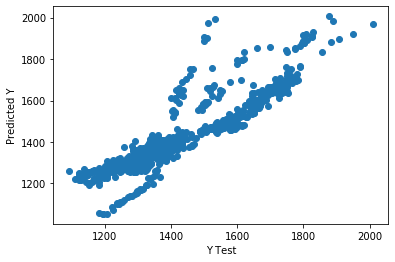

In [45]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

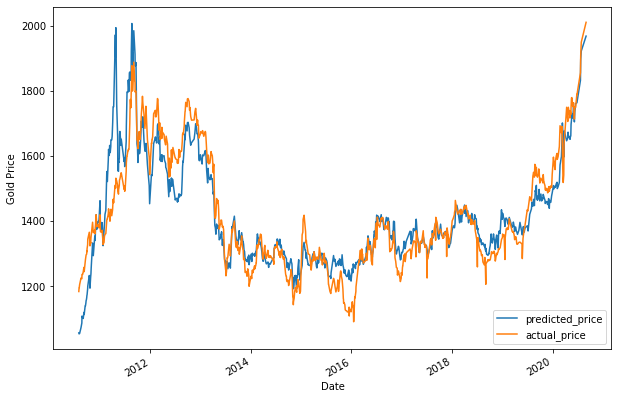

In [46]:
predictions = pd.DataFrame(
    predictions, index=y_test.index, columns=['Mid'])
predictions.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Price")
plt.show()

In [47]:
from sklearn import metrics
import numpy as np # linear algebra

print('MAE :'," ", metrics.mean_absolute_error(y_test,predictions))
print('MSE :'," ", metrics.mean_squared_error(y_test,predictions))
print('RMAE :'," ", np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE :   55.07492345216484
MSE :   5739.273127703049
RMAE :   75.75799052049261


In [48]:
r2_score = metrics.r2_score(y_test,predictions)
r2_score

0.8080150306497997

In [49]:
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(lm, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(lm, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())


Mean cross-validation score: 0.83
K-fold CV average score: 0.83


/Users/ibdigital/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/ibdigital/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ibdigital/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


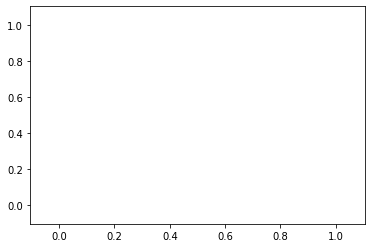

In [50]:
sns.distplot(y_test - predictions,bins=50)